# Rice disease v.0.1

Simple datasetwith 120 images, 3 classes (no class for healthy) from
https://archive.ics.uci.edu/ml/datasets/Rice+Leaf+Diseases#

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

import warnings
warnings.filterwarnings('ignore')

## Params

In [2]:
RANDOM_SEED = 9
TRAIN_SIZE = 0.5
VALID_SIZE = 0.25
TEST_SIZE  = 0.25

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

BATCH_SIZE = 10
LEARNING_RATE = 0.001

GPU = True
DATALOADER_PIN_MEMORY = GPU
DATALOADER_NUM_WORKERS = 1

## Utils

In [3]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [4]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

## Data

In [5]:
data_folder = 'data/archive.ics.120small'

In [6]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [18]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(15),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'test':  transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [19]:
print(cls_counts)
print('Total: ', len(all_data))

{'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf smut': 40}
Total:  120


In [20]:
all_indices = list(range(len(all_data)))
np.random.shuffle(all_indices)

train_len = int(len(all_data)*TRAIN_SIZE)
valid_len = int(len(all_data)*VALID_SIZE)
test_len  = int(len(all_data)*TEST_SIZE)

train_indices = all_indices[:train_len]
valid_indices = all_indices[train_len : train_len + valid_len]
test_indices  = all_indices[train_len + valid_len :]

assert set(train_indices) | set(valid_indices) | set(test_indices) == set(all_indices)

In [21]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler  = SubsetRandomSampler(test_indices)

In [22]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=BATCH_SIZE, 
                          sampler=train_sampler,
                          pin_memory=DATALOADER_PIN_MEMORY,
                          num_workers=DATALOADER_NUM_WORKERS)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=BATCH_SIZE, 
                          sampler=valid_sampler,
                          pin_memory=DATALOADER_PIN_MEMORY,
                          num_workers=DATALOADER_NUM_WORKERS)
test_loader  = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['test']), 
                          batch_size=BATCH_SIZE, 
                          sampler=test_sampler,
                          pin_memory=DATALOADER_PIN_MEMORY,
                          num_workers=DATALOADER_NUM_WORKERS)

Labels:
 [[2 2 2 2 0 0 1 1 1 0]
 [0 1 0 1 2 2 0 0 1 2]
 [1 0 1 0 0 2 1 0 1 2]
 [2 2 2 0 2 0 2 2 0 1]
 [0 1 0 2 1 0 0 0 1 0]
 [0 2 2 2 0 1 1 1 1 2]]

Classes: Leaf smut | Leaf smut | Leaf smut | Leaf smut | Bacterial leaf blight ...


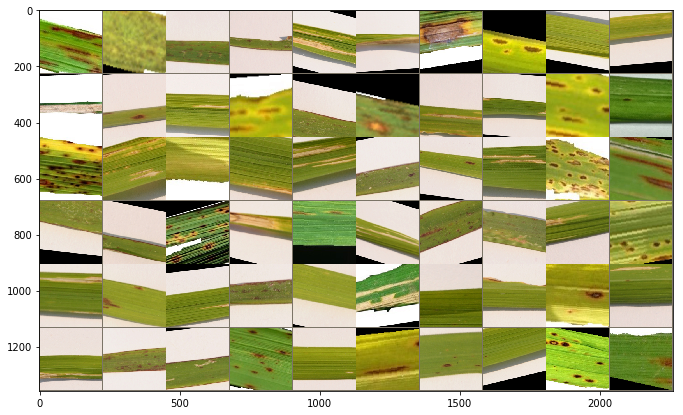

In [24]:
show_images(train_loader, all_data.classes, nrow=10, n_batches=None, figsize=(28, 7))

Labels:
 [[1 0 1 0 1 0]
 [1 2 2 2 2 2]
 [0 2 1 0 0 0]
 [2 0 0 2 1 2]
 [1 1 0 2 1 0]]

Classes: Brown spot | Bacterial leaf blight | Brown spot | Bacterial leaf blight | Brown spot ...


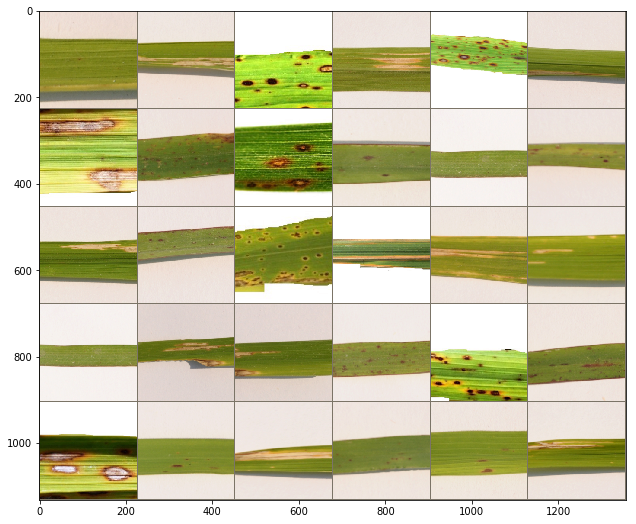

In [26]:
show_images(test_loader, all_data.classes, nrow=6, n_batches=None, figsize=(14, 9))